               Start_Time                End_Time  GPU_Utilization  \
0 1900-01-01 03:10:54.760 1900-01-01 03:10:55.140                0   
1 1900-01-01 03:10:55.140 1900-01-01 03:10:56.170                0   
2 1900-01-01 03:10:56.170 1900-01-01 03:10:57.110                0   
3 1900-01-01 03:10:57.110 1900-01-01 03:10:58.130                0   
4 1900-01-01 03:10:58.140 1900-01-01 03:10:59.150                0   

   Cumulative_Start_Seconds  Cumulative_End_Seconds  
0                      0.01                    0.39  
1                      0.39                    1.42  
2                      1.42                    2.36  
3                      2.36                    3.38  
4                      3.39                    4.40  
  Classifier           Feature_Extractor              Start_Time  \
0   logistic         tfidf_pareto_minmax 1900-01-01 03:10:54.750   
1   logistic  tfidf_l2_normalize_sigmoid 1900-01-01 03:15:19.850   
2   logistic                tfidfsigmoid 1900-01-01

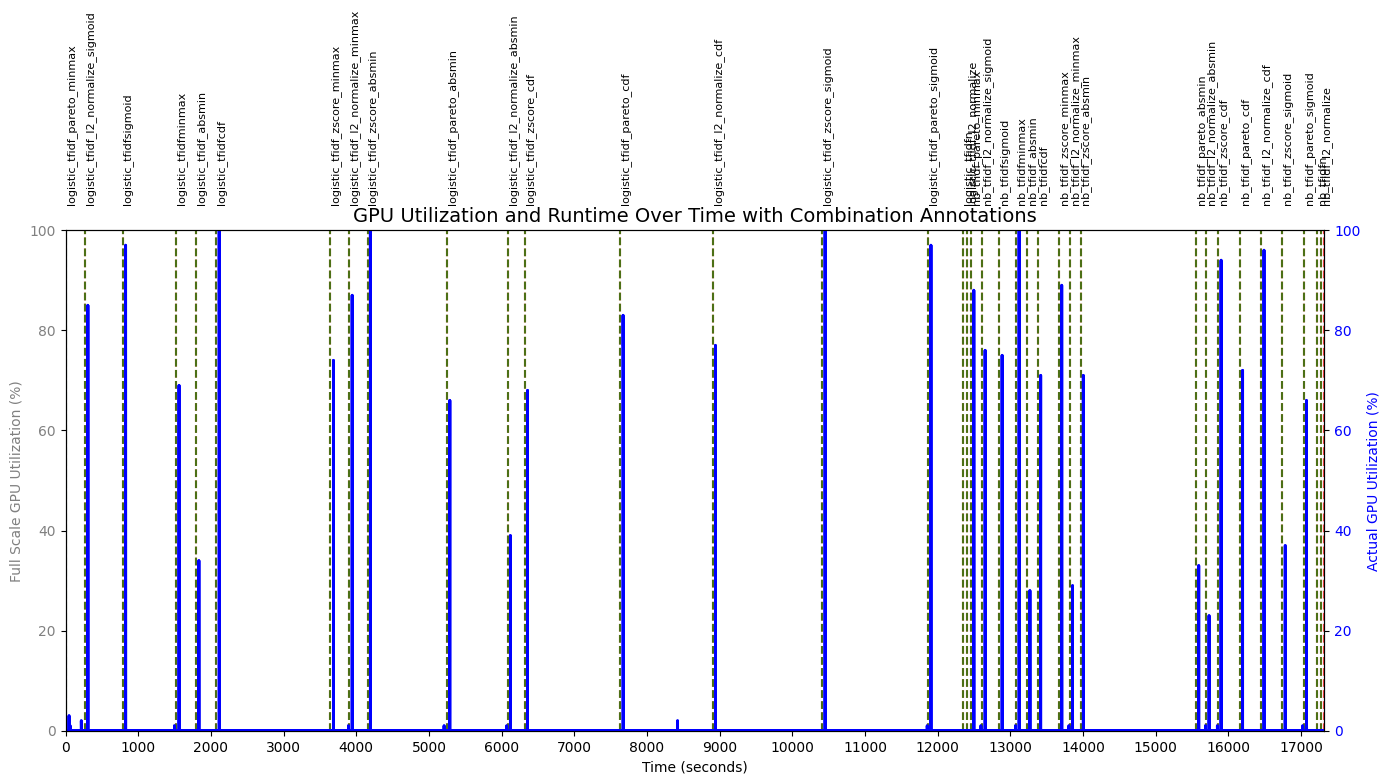


First few rows of GPU DataFrame:
               Start_Time                End_Time  GPU_Utilization  \
0 1900-01-01 03:10:54.760 1900-01-01 03:10:55.140                0   
1 1900-01-01 03:10:55.140 1900-01-01 03:10:56.170                0   
2 1900-01-01 03:10:56.170 1900-01-01 03:10:57.110                0   
3 1900-01-01 03:10:57.110 1900-01-01 03:10:58.130                0   
4 1900-01-01 03:10:58.140 1900-01-01 03:10:59.150                0   

   Cumulative_Start_Seconds  Cumulative_End_Seconds  
0                      0.01                    0.39  
1                      0.39                    1.42  
2                      1.42                    2.36  
3                      2.36                    3.38  
4                      3.39                    4.40  

First few rows of Combination DataFrame:
  Classifier           Feature_Extractor              Start_Time  \
0   logistic         tfidf_pareto_minmax 1900-01-01 03:10:54.750   
1   logistic  tfidf_l2_normalize_sigmoid 19

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log files
gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
            elif line.startswith('utilization.gpu [%]'):
                gpu_util = int(lines[i + 1].strip().replace('%', ''))
                end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                gpu_data.append((start_time, end_time, gpu_util))
                i += 2  # Skip 'Time end' line
            i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Convert datetime columns to timestamps
gpu_df['Start_Time'] = pd.to_datetime(gpu_df['Start_Time'])
gpu_df['End_Time'] = pd.to_datetime(gpu_df['End_Time'])
comb_df['Start_Time'] = pd.to_datetime(comb_df['Start_Time'])
comb_df['End_Time'] = pd.to_datetime(comb_df['End_Time'])

# Calculate the runtime for each combination
comb_df['Runtime_Seconds'] = (comb_df['End_Time'] - comb_df['Start_Time']).dt.total_seconds()

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Initialize columns for GPU utilization cumulative seconds
gpu_df['Cumulative_Start_Seconds'] = 0.0
gpu_df['Cumulative_End_Seconds'] = 0.0

# Calculate GPU utilization seconds based on cumulative runtime
for i, row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= row['Start_Time']) & (gpu_df['End_Time'] <= row['End_Time'])
    gpu_df.loc[mask, 'Cumulative_Start_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df.loc[mask, 'Start_Time'] - row['Start_Time']).dt.total_seconds()
    gpu_df.loc[mask, 'Cumulative_End_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df.loc[mask, 'End_Time'] - row['Start_Time']).dt.total_seconds()

# Display updated DataFrame for verification
print(gpu_df.head())
print(comb_df.head())

# Check for any empty columns
print("Empty columns in gpu_df:")
print(gpu_df.isnull().sum())
print("Empty columns in comb_df:")
print(comb_df.isnull().sum())

print("GPU DataFrame:")
print(gpu_df.describe())
print("\nCombination DataFrame:")
print(comb_df.describe())

# Modify the plotting section:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Cumulative_Start_Seconds'], row['Cumulative_End_Seconds']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

print(f"GPU Times range: {min(gpu_times)} to {max(gpu_times)}")
print(f"GPU Utilizations range: {min(gpu_utils)} to {max(gpu_utils)}")

if len(gpu_times) > 0 and len(gpu_utils) > 0:
    ax1.plot(gpu_times, gpu_utils, color='b', linewidth=2)  # Increased line width
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(gpu_times, gpu_utils, color='b', linewidth=2)
    
    # Set y-axis limits based on actual data range for ax2
    utilization_min = max(0, min(gpu_utils) - 5)  # Add some padding below
    utilization_max = min(100, max(gpu_utils) + 5)  # Add some padding above
    ax2.set_ylim(utilization_min, utilization_max)
    ax2.set_ylabel('Actual GPU Utilization (%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
else:
    print("Warning: No GPU utilization data to plot")

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Full Scale GPU Utilization (%)', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_ylim(0, 100)  # Keep the full 0-100% scale on the left axis

# Annotate the plot with combinations and runtime
for _, row in comb_df.iterrows():
    ax1.axvline(x=row['Cumulative_Start_Seconds'], color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=row['Cumulative_End_Seconds'], color='r', linestyle='--', alpha=0.7)
    ax1.text(row['Cumulative_Start_Seconds'], 105, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8)

# Set x-axis limits to cover the entire runtime
total_runtime = comb_df['Runtime_Seconds'].sum()
ax1.set_xlim(0, max(total_runtime, 1))  # Ensure the x-axis is at least 1 second wide

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))  # Adjust the number as needed
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.xticks(rotation=45)

# Add title and adjust layout
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)
fig.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", bbox_inches='tight')

# Display the plot
plt.show()

# Additional debugging: print the first few rows of each DataFrame
print("\nFirst few rows of GPU DataFrame:")
print(gpu_df.head())
print("\nFirst few rows of Combination DataFrame:")
print(comb_df.head())


               Start_Time                End_Time  GPU_Utilization  \
0 1900-01-01 03:10:54.760 1900-01-01 03:10:55.140                0   
1 1900-01-01 03:10:55.140 1900-01-01 03:10:56.170                0   
2 1900-01-01 03:10:56.170 1900-01-01 03:10:57.110                0   
3 1900-01-01 03:10:57.110 1900-01-01 03:10:58.130                0   
4 1900-01-01 03:10:58.140 1900-01-01 03:10:59.150                0   

   Cumulative_Start_Seconds  Cumulative_End_Seconds  
0                      0.01                    0.39  
1                      0.39                    1.42  
2                      1.42                    2.36  
3                      2.36                    3.38  
4                      3.39                    4.40  
  Classifier           Feature_Extractor              Start_Time  \
0   logistic         tfidf_pareto_minmax 1900-01-01 03:10:54.750   
1   logistic  tfidf_l2_normalize_sigmoid 1900-01-01 03:15:19.850   
2   logistic                tfidfsigmoid 1900-01-01

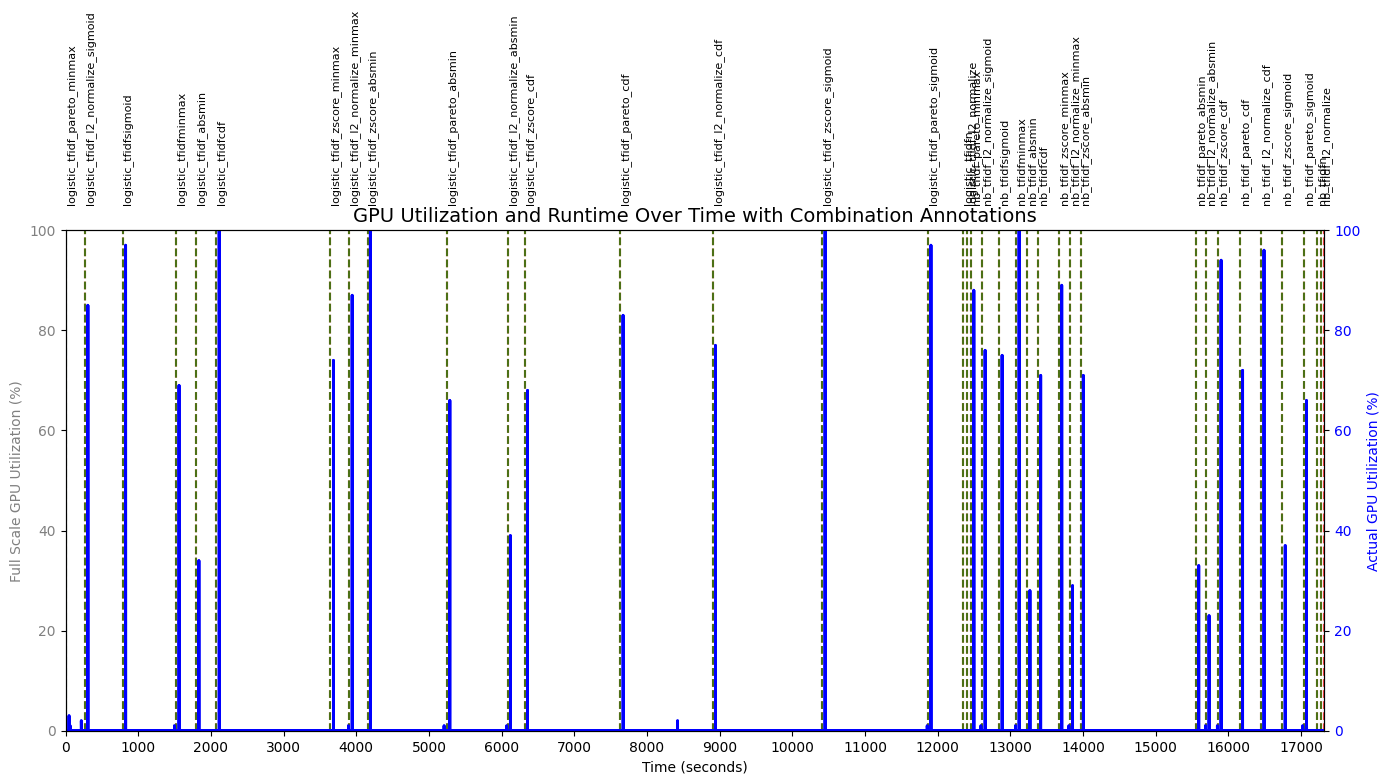


First few rows of GPU DataFrame:
               Start_Time                End_Time  GPU_Utilization  \
0 1900-01-01 03:10:54.760 1900-01-01 03:10:55.140                0   
1 1900-01-01 03:10:55.140 1900-01-01 03:10:56.170                0   
2 1900-01-01 03:10:56.170 1900-01-01 03:10:57.110                0   
3 1900-01-01 03:10:57.110 1900-01-01 03:10:58.130                0   
4 1900-01-01 03:10:58.140 1900-01-01 03:10:59.150                0   

   Cumulative_Start_Seconds  Cumulative_End_Seconds  
0                      0.01                    0.39  
1                      0.39                    1.42  
2                      1.42                    2.36  
3                      2.36                    3.38  
4                      3.39                    4.40  

First few rows of Combination DataFrame:
  Classifier           Feature_Extractor              Start_Time  \
0   logistic         tfidf_pareto_minmax 1900-01-01 03:10:54.750   
1   logistic  tfidf_l2_normalize_sigmoid 19

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log files
gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
            elif line.startswith('utilization.gpu [%]'):
                gpu_util = int(lines[i + 1].strip().replace('%', ''))
                end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                gpu_data.append((start_time, end_time, gpu_util))
                i += 2  # Skip 'Time end' line
            i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Convert datetime columns to timestamps
gpu_df['Start_Time'] = pd.to_datetime(gpu_df['Start_Time'])
gpu_df['End_Time'] = pd.to_datetime(gpu_df['End_Time'])
comb_df['Start_Time'] = pd.to_datetime(comb_df['Start_Time'])
comb_df['End_Time'] = pd.to_datetime(comb_df['End_Time'])

# Calculate the runtime for each combination
comb_df['Runtime_Seconds'] = (comb_df['End_Time'] - comb_df['Start_Time']).dt.total_seconds()

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Initialize columns for GPU utilization cumulative seconds
gpu_df['Cumulative_Start_Seconds'] = 0.0
gpu_df['Cumulative_End_Seconds'] = 0.0

# Calculate GPU utilization seconds based on cumulative runtime
for i, row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= row['Start_Time']) & (gpu_df['End_Time'] <= row['End_Time'])
    gpu_df.loc[mask, 'Cumulative_Start_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df.loc[mask, 'Start_Time'] - row['Start_Time']).dt.total_seconds()
    gpu_df.loc[mask, 'Cumulative_End_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df.loc[mask, 'End_Time'] - row['Start_Time']).dt.total_seconds()

# Display updated DataFrame for verification
print(gpu_df.head())
print(comb_df.head())

# Check for any empty columns
print("Empty columns in gpu_df:")
print(gpu_df.isnull().sum())
print("Empty columns in comb_df:")
print(comb_df.isnull().sum())

print("GPU DataFrame:")
print(gpu_df.describe())
print("\nCombination DataFrame:")
print(comb_df.describe())

# Modify the plotting section:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Cumulative_Start_Seconds'], row['Cumulative_End_Seconds']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

print(f"GPU Times range: {min(gpu_times)} to {max(gpu_times)}")
print(f"GPU Utilizations range: {min(gpu_utils)} to {max(gpu_utils)}")

if len(gpu_times) > 0 and len(gpu_utils) > 0:
    ax1.plot(gpu_times, gpu_utils, color='b', linewidth=2)  # Increased line width
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(gpu_times, gpu_utils, color='b', linewidth=2)
    
    # Set y-axis limits based on actual data range for ax2
    utilization_min = max(0, min(gpu_utils) - 5)  # Add some padding below
    utilization_max = min(100, max(gpu_utils) + 5)  # Add some padding above
    ax2.set_ylim(utilization_min, utilization_max)
    ax2.set_ylabel('Actual GPU Utilization (%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
else:
    print("Warning: No GPU utilization data to plot")

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Full Scale GPU Utilization (%)', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_ylim(0, 100)  # Keep the full 0-100% scale on the left axis

# Annotate the plot with combinations and runtime
for _, row in comb_df.iterrows():
    ax1.axvline(x=row['Cumulative_Start_Seconds'], color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=row['Cumulative_End_Seconds'], color='r', linestyle='--', alpha=0.7)
    ax1.text(row['Cumulative_Start_Seconds'], 105, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8)

# Set x-axis limits to cover the entire runtime
total_runtime = comb_df['Runtime_Seconds'].sum()
ax1.set_xlim(0, max(total_runtime, 1))  # Ensure the x-axis is at least 1 second wide

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))  # Adjust the number as needed
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.xticks(rotation=45)

# Add title and adjust layout
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)
fig.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", bbox_inches='tight')

# Display the plot
plt.show()

# Additional debugging: print the first few rows of each DataFrame
print("\nFirst few rows of GPU DataFrame:")
print(gpu_df.head())
print("\nFirst few rows of Combination DataFrame:")
print(comb_df.head())

def calculate_avg_gpu_utilization(gpu_df, comb_row):
    mask = (gpu_df['Cumulative_Start_Seconds'] >= comb_row['Cumulative_Start_Seconds']) & (gpu_df['Cumulative_End_Seconds'] <= comb_row['Cumulative_End_Seconds'])
    avg_utilization = gpu_df.loc[mask, 'GPU_Utilization'].mean()
    return avg_utilization if not pd.isna(avg_utilization) else 0

# Create a new DataFrame for the table
table_data = []
for _, row in comb_df.iterrows():
    avg_gpu_util = calculate_avg_gpu_utilization(gpu_df, row)
    table_data.append({
        'Classifier': row['Classifier'],
        'Feature_Extractor': row['Feature_Extractor'],
        'Runtime_Seconds': row['Runtime_Seconds'],
        'Avg_GPU_Utilization': avg_gpu_util
    })

table_df = pd.DataFrame(table_data)

# Sort the table by runtime (descending order)
table_df = table_df.sort_values('Runtime_Seconds', ascending=False)

# Display the table
print("\nCombinations, Runtime, and Average GPU Utilization:")
print(table_df)

# Save the table to a CSV file
table_df.to_csv('combinations_runtime_gpu_utilization.csv', index=False)
print("\nTable saved to 'combinations_runtime_gpu_utilization.csv'")

# Optionally, you can also save it as an Excel file
table_df.to_excel('combinations_runtime_gpu_utilization.xlsx', index=False)
print("Table saved to 'combinations_runtime_gpu_utilization.xlsx'")

# If you want to display the table in a more formatted way, you can use tabulate
from tabulate import tabulate
print("\nFormatted Table:")
print(tabulate(table_df, headers='keys', tablefmt='pretty'))
